# Altimetry

Some description

In [1]:
#import libraries
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import sys
from lib import geost1D, bounds, quiver_comp
#plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl

## Select area and cycle

In [8]:
min_lon, max_lon = -76, -73
min_lat, max_lat = 36.5, 39.5
min_cycle, max_cycle = 1019, 1019

## Load the dataset

In [44]:
#some description

In [9]:
#load file of selected track
loc = "./data/SLAFILT/ctoh.sla.filt.ref.TP+J1+J2+J3.gulfstream.228.nc"
ds = xr.open_dataset(loc)
#assign coordinates
ds = ds.rename({"missions_cycles": "cycles", "cycle":"xtrack_cycle"}).set_coords(["lat", "lon", "cycles"])
#subset by set bounds
point_idx, cycle_idx = bounds(ds.lat.data, 
                              ds.lon.data, 
                              ds.xtrack_cycle.data, 
                              min_lat, 
                              max_lat, 
                              min_lon, 
                              max_lon, 
                              min_cycle, 
                              max_cycle)
ds = ds.isel(nbpoints = point_idx, nbcycles = cycle_idx)
cycle_array = ds.xtrack_cycle.data
#converting JulianTime to datetime (TBC)
#print(ds['time'])
#dt_idx = ds.index["time"].to_datetimeindex()
#ds['time'] = dt_idx
ds

<xarray.Dataset>
Dimensions:               (nbpoints: 49, nbcycles: 1)
Coordinates:
    lon                   (nbpoints) float32 -73.33 -73.36 ... -74.86 -74.88
    lat                   (nbpoints) float32 36.54 36.58 36.63 ... 38.85 38.89
    cycles                (nbcycles) float32 ...
Dimensions without coordinates: nbpoints, nbcycles
Data variables:
    mssh                  (nbpoints) float32 ...
    xtrack_cycle          (nbcycles) int32 1019
    point                 (nbpoints) int32 ...
    time                  (nbpoints, nbcycles) object ...
    sla                   (nbpoints, nbcycles) float32 ...
    tide                  (nbpoints, nbcycles) float32 ...
    dac                   (nbpoints, nbcycles) float32 ...
    dist_to_coast_gshhs   (nbpoints) float64 ...
    dist_to_coast_stumpf  (nbpoints) float64 ...
    mdt_cnes_cls_18       (nbpoints) float64 ...
Attributes:
    title:        CTOH Along track Sea Level Anomalies
    institution:  CTOH/LEGOS, Toulouse Univ., CNRS, IRD, CNES, UPS, France
    Conventions:  CF-1.6
    history:      creation: 2020/09/10
    contact:      ctoh_products@legos.obs-mip.fr  http://ctoh.legos.obs-mip.fr
    version:      Version X-TRACK: 1.03.post18 - Version mercurial: hgcad1f04...
    doi:          10.6096/CTOH_X-TRACK_2017_02
    reference:    Birol, F. et al. “Coastal Applications from Nadir Altimetry...
    pass_number:  228
    handbook:     https://www.aviso.altimetry.fr/fileadmin/documents/data/too...

## Calculate across-track geostrophic current speed

In [ ]:
#describing what is done

In [10]:
#initalise array
u_geo = np.nan * ds.sla.data
#run for each cycle
for i in enumerate(cycle_array):
    #select respective data slice
    sel_cycle = ds.isel(nbcycles = i[0])
    sel_point = ds.isel(nbcycles = 0)
    #calculate geostrophic speeds for the cycle (dynamic comp)
    u_geo[:, i[0]] = geost1D(sel_cycle.lon.data, sel_cycle.lat.data, 1, sel_cycle.sla.data)
    #create DataArray for time and sea level anomaly
    time_da = xr.DataArray(data = ds.time.data, 
                           dims = ["loc", "cycle"], 
                           coords = dict(lat = ("loc", ds.lat.data),
                                         lon = ("loc", ds.lon.data), 
                                         cycle = ("cycle", ds.cycles.data.astype('int'))))
    sla_da = xr.DataArray(data = ds.sla.data, 
                          dims = ["loc", "cycle"], 
                          coords = dict(lat = ("loc", ds.lat.data),
                                        lon = ("loc", ds.lon.data), 
                                        cycle = ("cycle", ds.cycles.data.astype('int'))))
#convert to DataArray
u_geo = xr.DataArray(data = u_geo, dims = ["loc", "cycle"], 
                     coords = dict(lat = ("loc", ds.lat.data),
                                   lon = ("loc", ds.lon.data),
                                   cycle = ("cycle", ds.cycles.data.astype('int'))))
#calculate mean geostrophic speeds (mean comp) and convert to DataArray
u_mean = geost1D(sel_point.lon.data, sel_point.lat.data, 1, sel_point.mdt_cnes_cls_18.data)
u_mean = xr.DataArray(data = u_mean, dims = ["loc"], coords = dict(lat = ("loc", ds.lat.data),
                                                                  lon = ("loc", ds.lon.data)))
#calculate total geostrophic speed
u_total = u_geo + u_mean

#calculate zonal and meridional component
x_comp = np.nan * ds.sla.data
y_comp = np.nan * ds.sla.data
v_angle = np.nan * ds.sla.data
for i in enumerate(cycle_array):
    u_total_sel = u_total.isel(cycle = i[0])
    x_comp[:, i[0]], y_comp[:, i[0]], v_angle[:, i[0]], _ = quiver_comp(u_total_sel.data, 
                                                                        u_total_sel.lat.data, 
                                                                        u_total_sel.lon.data)
x_comp = xr.DataArray(data = x_comp, 
                      dims = ["loc", "cycle"], 
                      coords = dict(lat = ("loc", ds.lat.data),
                                    lon = ("loc", ds.lon.data),
                                    cycle = ("cycle", ds.cycles.data.astype('int'))))
y_comp = xr.DataArray(data = x_comp, 
                      dims = ["loc", "cycle"], 
                      coords = dict(lat = ("loc", ds.lat.data),
                                    lon = ("loc", ds.lon.data),
                                    cycle = ("cycle", ds.cycles.data.astype('int'))))
v_angle = xr.DataArray(data = v_angle, 
                       dims = ["loc", "cycle"], 
                       coords = dict(lat = ("loc", ds.lat.data), 
                                     lon = ("loc", ds.lon.data), 
                                     cycle = ("cycle", ds.cycles.data.astype('int'))))

In [11]:
#checks
#len(u_total.data[~np.isnan(u_total.data)])
len(y_comp.data[~np.isnan(y_comp.data)])

40

In [12]:
#create a dataset
geostrophic = xr.Dataset(data_vars = {"u_total": u_total, "u_geo": u_geo, "time": time_da, 
                                      "u_mean": u_mean, "x_comp": x_comp, "y_comp": y_comp,
                                      "current_angle": v_angle, "sla": sla_da})
geostrophic

<xarray.Dataset>
Dimensions:        (loc: 49, cycle: 1)
Coordinates:
    lat            (loc) float32 36.54 36.58 36.63 36.68 ... 38.8 38.85 38.89
    lon            (loc) float32 -73.33 -73.36 -73.39 ... -74.83 -74.86 -74.88
  * cycle          (cycle) int64 157
Dimensions without coordinates: loc
Data variables:
    u_total        (loc, cycle) float64 nan nan 1.946 ... -0.6449 -0.5978 nan
    u_geo          (loc, cycle) float32 nan nan 1.18 ... -0.4791 -0.4533 nan
    time           (loc, cycle) object 2020-05-22 03:35:03.640416 ... 2020-05...
    u_mean         (loc) float64 nan 0.8502 0.7662 ... -0.1658 -0.1445 nan
    x_comp         (loc, cycle) float32 nan nan 1.642 ... -0.5442 -0.5044 nan
    y_comp         (loc, cycle) float32 nan nan 1.642 ... -0.5442 -0.5044 nan
    current_angle  (loc, cycle) float32 0.5665 0.5665 0.5665 ... 0.5665 0.5665
    sla            (loc, cycle) float32 nan 0.3768 0.3048 ... 0.1596 0.2066

## Save the file

In [55]:
geostrophic.to_netcdf("./data/alt_ugeo.nc")

## Download HFR data to compare with alongtrack altimetry

In [14]:
#open dataset
hfr_ds = xr.open_dataset("./data/hf_radar_05_2020.nc")
#select nearest time option
hfr_ds = hfr_ds.sel(time = "2020-05-22T04:00:00")
hfr_ds

<xarray.Dataset>
Dimensions:                (time_1: 1, nv: 2, lon: 52, lat: 56)
Coordinates:
  * lat                    (lat) float32 36.52 36.57 36.62 ... 39.37 39.43 39.48
  * lon                    (lon) float32 -75.99 -75.93 -75.87 ... -73.09 -73.03
    time                   datetime64[ns] 2020-05-22T04:00:00
    time_run               datetime64[ns] ...
Dimensions without coordinates: time_1, nv
Data variables: (12/14)
    time_bnds              (time_1, nv, lon, lat) float64 ...
    depth_bnds             (nv, lon, lat) float32 ...
    wgs84                  (lon, lat) float64 ...
    processing_parameters  (lon, lat) float64 ...
    radial_metadata        (lon, lat) float64 ...
    depth                  (lon, lat) float64 ...
    ...                     ...
    v                      (lat, lon) float32 ...
    dopx                   (lat, lon) float32 ...
    dopy                   (lat, lon) float32 ...
    hdop                   (lat, lon) float32 ...
    number_of_sites        (lat, lon) float32 ...
    number_of_radials      (lat, lon) float32 ...
Attributes: (12/31)
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202108050300siohfruwlsrtvusegc6km
    date_created:              2021-08-05T04:53:55Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    ...                        ...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_East_and_Gulf_Coast_6km_...

## Download CMEMS reanalysis

In [15]:
#open dataset
cmems_ds = xr.open_dataset("./data/CMEMS-global-analysis-forecast-phy-001-024-hourly-u-v.nc")
cmems_ds = cmems_ds.rename({"latitude": "lat", "longitude": "lon"})
#select nearest time option
cmems_ds = cmems_ds.sel(time = "2020-05-22T03:30:00")
cmems_ds

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 37, lon: 37)
Coordinates:
  * depth    (depth) float32 0.494
  * lat      (lat) float32 36.5 36.58 36.67 36.75 ... 39.25 39.33 39.42 39.5
    time     datetime64[ns] 2020-05-22T03:30:00
  * lon      (lon) float32 -76.0 -75.92 -75.83 -75.75 ... -73.17 -73.08 -73.0
Data variables:
    vo       (depth, lat, lon) float32 ...
    uo       (depth, lat, lon) float32 ...
Attributes: (12/25)
    title:                              hourly mean fields from Global Ocean ...
    easting:                            longitude
    northing:                           latitude
    history:                            2021/08/05 00:11:43 MERCATOR OCEAN Ne...
    source:                             MERCATOR PSY4QV3R1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              0.494025
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

## Visualize

/tmp/ipykernel_40/904844319.py:36: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  out=fig.colorbar(cp,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)


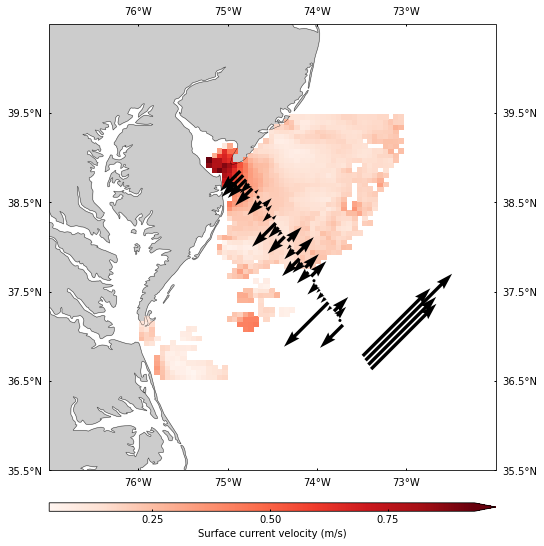

In [38]:
#ruthlessly copying Panagiotis's code
##only suitable for a single (!) cycle
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([min_lon-1, max_lon+1, min_lat-1, max_lat+1])

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

lon_ticks = np.arange(min_lon, max_lon+1, 1)
lat_ticks = np.arange(min_lat-1, max_lat+1, 1)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=True,labeltop=True,labelright=True)  

ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)
bounds = np.array([0.,0.25,0.5,0.75,1.])
norm = mpl.colors.Normalize(vmin=0., vmax=1.5)

xi, yi = np.meshgrid(hfr_ds.lon.data, hfr_ds.lat.data)
m = np.sqrt(hfr_ds.u.data*hfr_ds.u.data + hfr_ds.v.data*hfr_ds.v.data)

cp = ax.pcolor(xi, yi, m, cmap = plt.cm.Reds)
cf = ax.quiver(geostrophic.lon.data, geostrophic.lat.data, x_comp.data, y_comp.data)

cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cp,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)
out.set_label('Surface current velocity (m/s)',size=10)
out.ax.tick_params(direction='in',size=2., width=1)

plt.savefig('./img/alt_hfr.png', dpi=300, transparent=False, bbox_inches='tight')

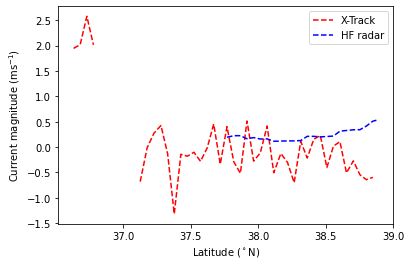

In [36]:
interp_method = 'nearest'
plot_xaxis_altimeter = geostrophic.lat.data
plot_yaxis_altimeter = geostrophic.u_total.data
plot_xaxis_hfr = hfr_ds.lat.interp(lat = geostrophic.lat)
plot_yaxis_hfr = np.sqrt(hfr_ds.u.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method)*
                         hfr_ds.u.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method) + 
                         hfr_ds.v.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method)*
                         hfr_ds.v.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(plot_xaxis_altimeter, plot_yaxis_altimeter, 'r--', label = 'X-Track')
ax.plot(plot_xaxis_hfr, plot_yaxis_hfr, 'b--', label = 'HF radar')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_ylabel(r'Current magnitude (ms$^{-1}$)')
ax.legend(loc = 'best')
plt.savefig("./img/alt_hfr_lineplot.png")

/srv/conda/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/tmp/ipykernel_40/303266308.py:33: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  out=fig.colorbar(cp,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)


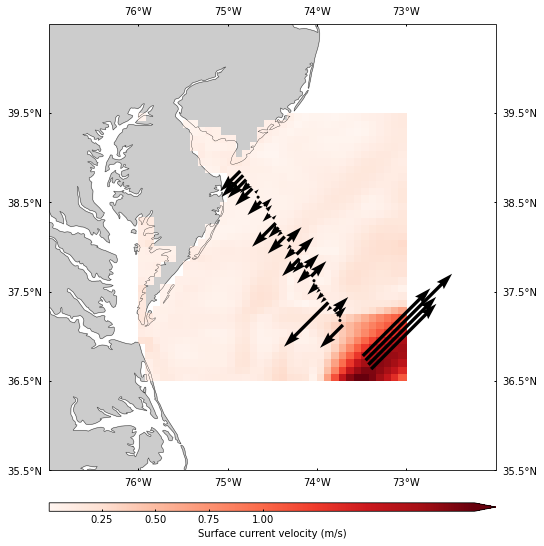

In [37]:
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([min_lon-1, max_lon+1, min_lat-1, max_lat+1])

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

lon_ticks = np.arange(min_lon, max_lon+1, 1)
lat_ticks = np.arange(min_lat-1, max_lat+1, 1)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=True,labeltop=True,labelright=True)  

ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)
bounds = np.array([0.,0.25,0.5,0.75,1.])
norm = mpl.colors.Normalize(vmin=0., vmax=1.5)

xi, yi = np.meshgrid(cmems_ds.lon.data, cmems_ds.lat.data)
m = np.sqrt(cmems_ds.uo.data*cmems_ds.uo.data + cmems_ds.vo.data*cmems_ds.vo.data)[0,:,:]
cp = ax.pcolor(xi, yi, m, cmap = plt.cm.Reds)
cf = ax.quiver(geostrophic.lon.data, geostrophic.lat.data, x_comp.data, y_comp.data)

cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cp,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)
out.set_label('Surface current velocity (m/s)',size=10)
out.ax.tick_params(direction='in',size=2., width=1)

plt.savefig('./img/alt_cmems.png', dpi=300, transparent=False, bbox_inches='tight')